In [1]:
import os, sys, time, glob, random, argparse
import numpy as np
from copy import deepcopy
import torch
import torch.nn as nn

# XAutoDL 
from xautodl.config_utils import load_config, dict2config, configure2str
from xautodl.datasets import get_datasets, get_nas_search_loaders
from xautodl.procedures import (
    prepare_seed,
    prepare_logger,
    save_checkpoint,
    copy_checkpoint,
    get_optim_scheduler,
)
from xautodl.utils import get_model_infos, obtain_accuracy
from xautodl.log_utils import AverageMeter, time_string, convert_secs2time
from xautodl.models import get_search_spaces

from custom_models import get_cell_based_tiny_net
from custom_search_cells import NAS201SearchCell as SearchCell
from xautodl.models.cell_searchs.genotypes import Structure

# NB201
from nas_201_api import NASBench201API as API

import scipy.stats as stats

2022-11-07 02:53:54.098392: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
parser = argparse.ArgumentParser("Random search for NAS.")
parser.add_argument("--data_path", type=str, default='../cifar.python', help="The path to dataset")
parser.add_argument("--dataset", type=str, default='cifar10',choices=["cifar10", "cifar100", "ImageNet16-120"], help="Choose between Cifar10/100 and ImageNet-16.")

# channels and number-of-cells
parser.add_argument("--search_space_name", type=str, default='nas-bench-201', help="The search space name.")
parser.add_argument("--config_path", type=str, default='./MY.config', help="The path to the configuration.")
parser.add_argument("--max_nodes", type=int, default=4, help="The maximum number of nodes.")
parser.add_argument("--channel", type=int, default=16, help="The number of channels.")
parser.add_argument("--num_cells", type=int, default=5, help="The number of cells in one stage.")
parser.add_argument("--select_num", type=int, default=100, help="The number of selected architectures to evaluate.")
parser.add_argument("--track_running_stats", type=int, default=0, choices=[0, 1], help="Whether use track_running_stats or not in the BN layer.")
# log
parser.add_argument("--workers", type=int, default=4, help="number of data loading workers")
parser.add_argument("--save_dir", type=str, default='./cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200', help="Folder to save checkpoints and log.")
# parser.add_argument("--arch_nas_dataset", type=str, default='../NAS-Bench-201-v1_1-096897.pth', help="The path to load the architecture dataset (tiny-nas-benchmark).")
parser.add_argument("--arch_nas_dataset", type=str, default=None, help="The path to load the architecture dataset (tiny-nas-benchmark).")
parser.add_argument("--print_freq", type=int, default=200, help="print frequency (default: 200)")
parser.add_argument("--rand_seed", type=int, default=None, help="manual seed")
args = parser.parse_args(args=[])
if args.rand_seed is None or args.rand_seed < 0:
    args.rand_seed = random.randint(1, 100000)

    
print(args.rand_seed)
print(args)
xargs=args

74964
Namespace(arch_nas_dataset=None, channel=16, config_path='./MY.config', data_path='../cifar.python', dataset='cifar10', max_nodes=4, num_cells=5, print_freq=200, rand_seed=74964, save_dir='./cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200', search_space_name='nas-bench-201', select_num=100, track_running_stats=0, workers=4)


In [3]:
assert torch.cuda.is_available(), "CUDA is not available."
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.set_num_threads(xargs.workers)
prepare_seed(xargs.rand_seed)
logger = prepare_logger(args)

Main Function with logger : Logger(dir=cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200, use-tf=False, writer=None)
Arguments : -------------------------------
arch_nas_dataset : None
channel          : 16
config_path      : ./MY.config
data_path        : ../cifar.python
dataset          : cifar10
max_nodes        : 4
num_cells        : 5
print_freq       : 200
rand_seed        : 74964
save_dir         : ./cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200
search_space_name : nas-bench-201
select_num       : 100
track_running_stats : 0
workers          : 4
Python  Version  : 3.7.13 (default, Mar 29 2022, 02:18:16)  [GCC 7.5.0]
Pillow  Version  : 9.0.1
PyTorch Version  : 1.12.0
cuDNN   Version  : 8302
CUDA available   : True
CUDA GPU numbers : 2
CUDA_VISIBLE_DEVICES : None


In [4]:
train_data, valid_data, xshape, class_num = get_datasets(xargs.dataset, xargs.data_path, -1)
config = load_config(xargs.config_path, {"class_num": class_num, "xshape": xshape}, logger)
search_loader, _, valid_loader = get_nas_search_loaders(train_data,
                                                        valid_data,
                                                        xargs.dataset,
                                                        "../configs/nas-benchmark/",
                                                        (config.batch_size, config.test_batch_size),
                                                        xargs.workers)
logger.log("||||||| {:10s} ||||||| Search-Loader-Num={:}, Valid-Loader-Num={:}, batch size={:}".format(
            xargs.dataset, len(search_loader), len(valid_loader), config.batch_size))
logger.log("||||||| {:10s} ||||||| Config={:}".format(xargs.dataset, config))

search_space = get_search_spaces("cell", xargs.search_space_name)
model_config = dict2config(
    {
        "name": "RANDOM",
        "C": xargs.channel,
        "N": xargs.num_cells,
        "max_nodes": xargs.max_nodes,
        "num_classes": class_num,
        "space": search_space,
        "affine": False,
        "track_running_stats": bool(xargs.track_running_stats),
    },
    None,
)
search_model = get_cell_based_tiny_net(model_config)

w_optimizer, w_scheduler, criterion = get_optim_scheduler(search_model.parameters(), config)

logger.log("w-optimizer : {:}".format(w_optimizer))
logger.log("w-scheduler : {:}".format(w_scheduler))
logger.log("criterion   : {:}".format(criterion))
# if xargs.arch_nas_dataset is None:
api = None
# else:
#     api = API(xargs.arch_nas_dataset)
logger.log("{:} create API = {:} done".format(time_string(), api))

last_info, model_base_path, model_best_path = (
    logger.path("info"),
    logger.path("model"),
    logger.path("best"),
)
network, criterion = torch.nn.DataParallel(search_model).cuda(), criterion.cuda()

if last_info.exists():  # automatically resume from previous checkpoint
    logger.log(
        "=> loading checkpoint of the last-info '{:}' start".format(last_info)
    )
    last_info = torch.load(last_info)
    start_epoch = last_info["epoch"]
    checkpoint = torch.load(last_info["last_checkpoint"])
    genotypes = checkpoint["genotypes"]
    valid_accuracies = checkpoint["valid_accuracies"]
    search_model.load_state_dict(checkpoint["search_model"])
    w_scheduler.load_state_dict(checkpoint["w_scheduler"])
    w_optimizer.load_state_dict(checkpoint["w_optimizer"])
    logger.log(
        "=> loading checkpoint of the last-info '{:}' start with {:}-th epoch.".format(
            last_info, start_epoch
        )
    )
else:
    logger.log("=> do not find the last-info file : {:}".format(last_info))
    start_epoch, valid_accuracies, genotypes = 0, {"best": -1}, {}

Files already downloaded and verified
Files already downloaded and verified
./MY.config
Configure(scheduler='cos', LR=0.025, eta_min=0.001, epochs=50, warmup=0, optim='SGD', decay=0.0005, momentum=0.9, nesterov=True, criterion='Softmax', batch_size=64, test_batch_size=512, class_num=10, xshape=(1, 3, 32, 32))
||||||| cifar10    ||||||| Search-Loader-Num=391, Valid-Loader-Num=49, batch size=64
||||||| cifar10    ||||||| Config=Configure(scheduler='cos', LR=0.025, eta_min=0.001, epochs=50, warmup=0, optim='SGD', decay=0.0005, momentum=0.9, nesterov=True, criterion='Softmax', batch_size=64, test_batch_size=512, class_num=10, xshape=(1, 3, 32, 32))
w-optimizer : SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    initial_lr: 0.025
    lr: 0.025
    maximize: False
    momentum: 0.9
    nesterov: True
    weight_decay: 0.0005
)
w-scheduler : CosineAnnealingLR(warmup=0, max-epoch=50, current::epoch=0, iter=0.00, type=cosine, T-max=50, eta-min=0.001)
criterion   : CrossEntropyLoss(

In [5]:
def acc_confidence_robustness_metrics(network, inputs, targets):
    with torch.no_grad():
        # accuracy
        network.train()
        _, logits = network(inputs)
        val_top1, val_top5 = obtain_accuracy(logits.data, targets.data, topk=(1, 5))
        acc = val_top1
        
        # confidence
        prob = torch.nn.functional.softmax(logits, dim=1)
        one_hot_idx = torch.nn.functional.one_hot(targets)
        confidence = (prob[one_hot_idx==1].sum()) / inputs.size(0) * 100 # in percent
        
        # sensitivity
        _, noisy_logits = network(inputs + torch.randn_like(inputs)*0.1)
        kl_loss = torch.nn.KLDivLoss(reduction="batchmean")
        sensitivity = kl_loss(torch.nn.functional.log_softmax(noisy_logits, dim=1), torch.nn.functional.softmax(logits, dim=1))
        
        # robustness
        original_weights = deepcopy(network.state_dict())
        for m in network.modules():
            if isinstance(m, SearchCell):
                for p in m.parameters():
                    p.add_(torch.randn_like(p) * p.std()*0.3)
            
        _, noisy_logits = network(inputs)
        kl_loss = torch.nn.KLDivLoss(reduction="batchmean")
        robustness = -kl_loss(torch.nn.functional.log_softmax(noisy_logits, dim=1), torch.nn.functional.softmax(logits, dim=1))
        network.load_state_dict(original_weights)
                
        return acc.item(), confidence.item(), sensitivity.item(), robustness.item()
    
def step_sim_metric(network, criterion, inputs, targets):
#     inputs, targets = inputs[:64], targets[:64] # smaller batches
    original_dict = deepcopy(network.state_dict())
    optim_large_step = torch.optim.SGD(network.parameters(), lr=0.025)
    
    # single large step
    network.train()
    optim_large_step.zero_grad()
    _, logits = network(inputs)
    base_loss = criterion(logits, targets)
    base_loss.backward()
    optim_large_step.step()
    large_step_dict = deepcopy(network.state_dict())
    
    # multiple small steps
    network.load_state_dict(original_dict)
    optim_small_step = torch.optim.SGD(network.parameters(), lr=0.025/3)
    for i in range(3):
        optim_small_step.zero_grad()
        _, logits = network(inputs)
        base_loss = criterion(logits, targets)
        base_loss.backward()
        optim_small_step.step()
    small_step_dict = deepcopy(network.state_dict())
    scores = []
    for key in large_step_dict.keys():
        if ('weight' in key) and (original_dict[key].dim()==4):
            if (original_dict[key] != large_step_dict[key]).sum():
                large_step = large_step_dict[key] - original_dict[key]
                small_step = small_step_dict[key] - original_dict[key]
                co, ci, kh, kw = large_step.size()
                large_step = large_step.view(co, -1)
                small_step = small_step.view(co, -1)
                score = torch.nn.functional.cosine_similarity(large_step, small_step, dim=1)
                score = score.mean().item() * 100 # in percent
                scores.append(score)
    if len(scores)==0:
        step_sim = 100
        raise RuntimeError
    else:
        step_sim = np.mean(scores)
    
    # resume
    network.load_state_dict(original_dict)
            
    return step_sim

In [6]:
# start training
start_time, search_time, epoch_time, total_epoch = (
    time.time(),
    AverageMeter(),
    AverageMeter(),
    config.epochs + config.warmup,
)

################# initialize
cells = []
for m in network.modules():
    if isinstance(m, SearchCell):
        cells.append(m)
num_cells = len(cells)
print("total number of nodes:{}".format(num_cells*xargs.max_nodes))
        
op_names = deepcopy(cells[0].op_names)
op_names_wo_none = deepcopy(op_names)
if "none" in op_names_wo_none:
    op_names_wo_none.remove("none")

genotypes = []
for i in range(1, xargs.max_nodes):
    xlist = []
    for j in range(i):
        node_str = "{:}<-{:}".format(i, j)
        if i-j==1:
            op_name = "skip_connect"
        else:
            op_name = "none"
        xlist.append((op_name, j))
    genotypes.append(tuple(xlist))
init_arch = Structure(genotypes)

for c in cells:
    c.arch_cache = init_arch

### gen possible connections of a target node
possible_connections = {}
for target_node_idx in range(1,xargs.max_nodes):
    possible_connections[target_node_idx] = list()
    xlists = []
    for src_node in range(target_node_idx):
        node_str = "{:}<-{:}".format(target_node_idx, src_node)
        # select possible ops
#         if target_node_idx - src_node == 1:
#             op_names_tmp = op_names_wo_none
#         else:
#             op_names_tmp = op_names
        op_names_tmp = op_names
            
        if len(xlists) == 0: # initial iteration
            for op_name in op_names_tmp:
                xlists.append([(op_name, src_node)])
        else:
            new_xlists = []
            for op_name in op_names_tmp:
                for xlist in xlists:
                    new_xlist = deepcopy(xlist)
                    new_xlist.append((op_name, src_node))
                    new_xlists.append(new_xlist)
            xlists = new_xlists
    for xlist in xlists:
        selected_ops = []
        for l in xlist:
            selected_ops.append(l[0])
        if sum(np.array(selected_ops) == "none") == len(selected_ops):
            continue
        possible_connections[target_node_idx].append(tuple(xlist))
    print("target_node:{}".format(target_node_idx), len(possible_connections[target_node_idx]))
        
### train while generating random architectures by mutating connections of a target node

for arch_loop in range(5):
    for target_cell_idx in range(num_cells):
        target_cell = cells[target_cell_idx]
        print("\n\n Searching with a cell #{}".format(target_cell_idx))
        ####
#         for m in target_cell.modules():
#             if hasattr(m, 'reset_parameters'):
#                 m.reset_parameters()
        ####
        ## training
        for ep in range(2):
            ###
            genotypes = []
            for n in range(1, xargs.max_nodes):
                genotypes.append(random.choice(possible_connections[n]))
            arch = Structure(genotypes)
            target_cell.arch_cache = arch
#             arch = target_cell.random_genotype(True)
            ###
            data_time, batch_time = AverageMeter(), AverageMeter()
            base_losses, base_top1, base_top5 = AverageMeter(), AverageMeter(), AverageMeter()
            network.train()
            end = time.time()
            print_freq = 200
            for step, (base_inputs, base_targets, arch_inputs, arch_targets) in enumerate(search_loader):
                ######### forward/backward/optim
                base_targets = base_targets.cuda(non_blocking=True)
                arch_targets = arch_targets.cuda(non_blocking=True)
                # measure data loading time
                data_time.update(time.time() - end)
                w_optimizer.zero_grad()
                _, logits = network(base_inputs)
                base_loss = criterion(logits, base_targets)
                base_loss.backward()
                nn.utils.clip_grad_norm_(network.parameters(), 5)
                w_optimizer.step()

                ######### logging
                base_prec1, base_prec5 = obtain_accuracy(logits.data, base_targets.data, topk=(1, 5))
                base_losses.update(base_loss.item(), base_inputs.size(0))
                base_top1.update(base_prec1.item(), base_inputs.size(0))
                base_top5.update(base_prec5.item(), base_inputs.size(0))
                batch_time.update(time.time() - end)
                end = time.time()
                if step % print_freq == 0 or step + 1 == len(search_loader):
                    Sstr = ("*Train* "+ time_string()+" Ep:{:} [{:03d}/{:03d}]".format(ep, step, len(search_loader)))
                    Tstr = "Time {batch_time.val:.2f} ({batch_time.avg:.2f}) Data {data_time.val:.2f} ({data_time.avg:.2f})".format(batch_time=batch_time, data_time=data_time)
                    Wstr = "Base [Loss {loss.val:.3f} ({loss.avg:.3f})  Prec@1 {top1.val:.2f} ({top1.avg:.2f}) Prec@5 {top5.val:.2f} ({top5.avg:.2f})]".format(loss=base_losses, top1=base_top1, top5=base_top5)
                    logger.log(Sstr + " " + Tstr + " " + Wstr)

            logger.log("Ep:{:} ends : loss={:.2f}, accuracy@1={:.2f}%, accuracy@5={:.2f}%".format(ep, base_losses.avg, base_top1.avg, base_top5.avg))
        ## evaluation
        network.train()
        archs, metric_accs, metric_confidences, metric_sensitivities, metric_robustnesses, metric_step_sims = [], [], [], [], [], []
        loader_iter = iter(valid_loader)
        for search_iter in range(200):
            ###### random gen
            genotypes = []
            for n in range(1, xargs.max_nodes):
                genotypes.append(random.choice(possible_connections[n]))
            arch = Structure(genotypes)
            target_cell.arch_cache = arch
#             arch = target_cell.random_genotype(True)
            ###### measure metrics
            try:
                inputs, targets = next(loader_iter)
            except:
                loader_iter = iter(valid_loader)
                inputs, targets = next(loader_iter)
            inputs, targets = inputs.cuda(non_blocking=True), targets.cuda(non_blocking=True)
            valid_acc, confidence, sensitivity, robustness = acc_confidence_robustness_metrics(network, inputs, targets)
            step_sim = step_sim_metric(network, criterion, inputs, targets)
            archs.append(arch)
            metric_accs.append(valid_acc)
            metric_confidences.append(confidence)
            metric_sensitivities.append(sensitivity)
            metric_robustnesses.append(robustness)
            metric_step_sims.append(step_sim)
        rank_accs, rank_confidences, rank_sensitivities, rank_robustnesses, rank_step_sims = stats.rankdata(metric_accs), stats.rankdata(metric_confidences), stats.rankdata(metric_sensitivities), stats.rankdata(metric_robustnesses), stats.rankdata(metric_step_sims)
        l = len(rank_accs)
        rank_agg = np.log(rank_accs/l)+np.log(rank_confidences/l)+np.log(rank_sensitivities/l)+np.log(rank_robustnesses/l)+np.log(rank_step_sims/l)
#             rank_agg = np.log(rank_accs/l)+np.log(rank_confidences/l)+np.log(rank_sensitivities/l)+np.log(rank_step_sims/l)
        best_idx = np.argmax(rank_agg)
        best_arch, best_acc, best_conf, best_sensitivity, best_robust, best_step_sim = archs[best_idx], metric_accs[best_idx], metric_confidences[best_idx], metric_sensitivities[best_idx], metric_robustnesses[best_idx], metric_step_sims[best_idx]
        logger.log("Found best op for target cell:{}".format(target_cell_idx))
        logger.log(": {:} with accuracy={:.2f}%, confidence={:.3f}%, sensitivity={:.3f}, robustness={:.3f}, step_sim={:.3f}".format(best_arch, best_acc, best_conf, best_sensitivity, best_robust, best_step_sim))
        target_cell.arch_cache = best_arch
            
best_archs = []
for c in cells:
    best_archs.append(c.arch_cache)
    
torch.save({"model":search_model.state_dict(), "best_archs":best_archs}, os.path.join(xargs.save_dir, "output.pth"))

for m in search_model.modules():
    if isinstance(m, SearchCell):
        logger.log(m.arch_cache)

logger.close()

total number of nodes:60
target_node:1 4
target_node:2 24
target_node:3 124


 Searching with a cell #0
*Train* [2022-11-07 02:54:00] Ep:0 [000/391] Time 2.97 (2.97) Data 0.15 (0.15) Base [Loss 2.290 (2.290)  Prec@1 12.50 (12.50) Prec@5 57.81 (57.81)]
*Train* [2022-11-07 02:54:21] Ep:0 [200/391] Time 0.18 (0.12) Data 0.00 (0.00) Base [Loss 1.706 (1.804)  Prec@1 32.81 (31.61) Prec@5 84.38 (84.59)]
*Train* [2022-11-07 02:54:43] Ep:0 [390/391] Time 0.12 (0.12) Data 0.00 (0.00) Base [Loss 1.340 (1.671)  Prec@1 47.50 (37.48) Prec@5 97.50 (87.84)]
Ep:0 ends : loss=1.67, accuracy@1=37.48%, accuracy@5=87.84%
*Train* [2022-11-07 02:54:43] Ep:1 [000/391] Time 0.29 (0.29) Data 0.21 (0.21) Base [Loss 2.659 (2.659)  Prec@1 14.06 (14.06) Prec@5 67.19 (67.19)]
*Train* [2022-11-07 02:55:06] Ep:1 [200/391] Time 0.07 (0.12) Data 0.00 (0.00) Base [Loss 1.562 (1.481)  Prec@1 40.62 (45.13) Prec@5 89.06 (92.06)]
*Train* [2022-11-07 02:55:29] Ep:1 [390/391] Time 0.20 (0.12) Data 0.00 (0.00) Base [Loss 1.349 

*Train* [2022-11-07 03:21:33] Ep:1 [000/391] Time 0.33 (0.33) Data 0.23 (0.23) Base [Loss 1.127 (1.127)  Prec@1 59.38 (59.38) Prec@5 98.44 (98.44)]
*Train* [2022-11-07 03:22:01] Ep:1 [200/391] Time 0.13 (0.14) Data 0.00 (0.00) Base [Loss 0.809 (0.836)  Prec@1 64.06 (70.73) Prec@5 98.44 (97.81)]
*Train* [2022-11-07 03:22:23] Ep:1 [390/391] Time 0.13 (0.13) Data 0.00 (0.00) Base [Loss 0.618 (0.824)  Prec@1 82.50 (70.96) Prec@5 100.00 (97.86)]
Ep:1 ends : loss=0.82, accuracy@1=70.96%, accuracy@5=97.86%
Found best op for target cell:6
: Structure(4 nodes with |skip_connect~0|+|avg_pool_3x3~0|skip_connect~1|+|avg_pool_3x3~0|avg_pool_3x3~1|nor_conv_3x3~2|) with accuracy=63.67%, confidence=52.204%, sensitivity=0.098, robustness=-0.029, step_sim=99.672


 Searching with a cell #7
*Train* [2022-11-07 03:25:38] Ep:0 [000/391] Time 0.28 (0.28) Data 0.18 (0.18) Base [Loss 1.210 (1.210)  Prec@1 54.69 (54.69) Prec@5 96.88 (96.88)]
*Train* [2022-11-07 03:25:59] Ep:0 [200/391] Time 0.09 (0.11) Data 0.

Found best op for target cell:12
: Structure(4 nodes with |skip_connect~0|+|none~0|skip_connect~1|+|nor_conv_3x3~0|skip_connect~1|skip_connect~2|) with accuracy=77.34%, confidence=64.294%, sensitivity=0.092, robustness=-0.042, step_sim=99.973


 Searching with a cell #13
*Train* [2022-11-07 03:54:27] Ep:0 [000/391] Time 0.32 (0.32) Data 0.18 (0.18) Base [Loss 2.433 (2.433)  Prec@1 7.81 (7.81) Prec@5 67.19 (67.19)]
*Train* [2022-11-07 03:54:54] Ep:0 [200/391] Time 0.14 (0.13) Data 0.00 (0.00) Base [Loss 0.540 (0.751)  Prec@1 85.94 (74.35) Prec@5 100.00 (98.17)]
*Train* [2022-11-07 03:55:17] Ep:0 [390/391] Time 0.12 (0.13) Data 0.00 (0.00) Base [Loss 0.929 (0.730)  Prec@1 67.50 (75.04) Prec@5 97.50 (98.33)]
Ep:0 ends : loss=0.73, accuracy@1=75.04%, accuracy@5=98.33%
*Train* [2022-11-07 03:55:18] Ep:1 [000/391] Time 0.38 (0.38) Data 0.21 (0.21) Base [Loss 0.690 (0.690)  Prec@1 75.00 (75.00) Prec@5 100.00 (100.00)]
*Train* [2022-11-07 03:55:44] Ep:1 [200/391] Time 0.14 (0.13) Data 0.00 (0.

*Train* [2022-11-07 04:24:40] Ep:0 [390/391] Time 0.13 (0.12) Data 0.00 (0.00) Base [Loss 0.532 (0.753)  Prec@1 87.50 (74.00) Prec@5 95.00 (98.11)]
Ep:0 ends : loss=0.75, accuracy@1=74.00%, accuracy@5=98.11%
*Train* [2022-11-07 04:24:41] Ep:1 [000/391] Time 0.27 (0.27) Data 0.18 (0.18) Base [Loss 1.768 (1.768)  Prec@1 48.44 (48.44) Prec@5 85.94 (85.94)]
*Train* [2022-11-07 04:25:04] Ep:1 [200/391] Time 0.12 (0.12) Data 0.00 (0.00) Base [Loss 0.580 (0.716)  Prec@1 78.12 (75.01) Prec@5 98.44 (98.23)]
*Train* [2022-11-07 04:25:25] Ep:1 [390/391] Time 0.09 (0.11) Data 0.00 (0.00) Base [Loss 0.732 (0.710)  Prec@1 70.00 (75.24) Prec@5 100.00 (98.26)]
Ep:1 ends : loss=0.71, accuracy@1=75.24%, accuracy@5=98.26%
Found best op for target cell:4
: Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_3x3~0|none~1|+|skip_connect~0|none~1|none~2|) with accuracy=65.43%, confidence=56.045%, sensitivity=0.173, robustness=-0.105, step_sim=99.852


 Searching with a cell #5
*Train* [2022-11-07 04:28:50] Ep:

Found best op for target cell:10
: Structure(4 nodes with |avg_pool_3x3~0|+|avg_pool_3x3~0|avg_pool_3x3~1|+|none~0|nor_conv_3x3~1|skip_connect~2|) with accuracy=77.15%, confidence=69.768%, sensitivity=0.139, robustness=-0.065, step_sim=99.937


 Searching with a cell #11
*Train* [2022-11-07 04:58:54] Ep:0 [000/391] Time 0.28 (0.28) Data 0.18 (0.18) Base [Loss 0.620 (0.620)  Prec@1 73.44 (73.44) Prec@5 100.00 (100.00)]
*Train* [2022-11-07 04:59:17] Ep:0 [200/391] Time 0.09 (0.12) Data 0.00 (0.00) Base [Loss 0.488 (0.595)  Prec@1 82.81 (79.59) Prec@5 100.00 (98.82)]
*Train* [2022-11-07 04:59:41] Ep:0 [390/391] Time 0.13 (0.12) Data 0.00 (0.00) Base [Loss 0.683 (0.596)  Prec@1 72.50 (79.61) Prec@5 100.00 (98.83)]
Ep:0 ends : loss=0.60, accuracy@1=79.61%, accuracy@5=98.83%
*Train* [2022-11-07 04:59:42] Ep:1 [000/391] Time 0.40 (0.40) Data 0.21 (0.21) Base [Loss 0.818 (0.818)  Prec@1 67.19 (67.19) Prec@5 96.88 (96.88)]
*Train* [2022-11-07 05:00:03] Ep:1 [200/391] Time 0.15 (0.11) Data 0.00 

*Train* [2022-11-07 05:31:07] Ep:0 [390/391] Time 0.09 (0.11) Data 0.00 (0.00) Base [Loss 0.789 (0.607)  Prec@1 77.50 (79.02) Prec@5 92.50 (98.78)]
Ep:0 ends : loss=0.61, accuracy@1=79.02%, accuracy@5=98.78%
*Train* [2022-11-07 05:31:07] Ep:1 [000/391] Time 0.29 (0.29) Data 0.18 (0.18) Base [Loss 1.882 (1.882)  Prec@1 42.19 (42.19) Prec@5 90.62 (90.62)]
*Train* [2022-11-07 05:31:31] Ep:1 [200/391] Time 0.11 (0.12) Data 0.00 (0.00) Base [Loss 0.589 (0.595)  Prec@1 78.12 (79.21) Prec@5 100.00 (98.88)]
*Train* [2022-11-07 05:31:52] Ep:1 [390/391] Time 0.08 (0.12) Data 0.00 (0.00) Base [Loss 0.380 (0.579)  Prec@1 82.50 (79.82) Prec@5 100.00 (98.94)]
Ep:1 ends : loss=0.58, accuracy@1=79.82%, accuracy@5=98.94%
Found best op for target cell:2
: Structure(4 nodes with |nor_conv_1x1~0|+|skip_connect~0|avg_pool_3x3~1|+|nor_conv_1x1~0|none~1|none~2|) with accuracy=75.39%, confidence=67.021%, sensitivity=0.220, robustness=-0.072, step_sim=99.881


 Searching with a cell #3
*Train* [2022-11-07 05:3

Found best op for target cell:8
: Structure(4 nodes with |nor_conv_1x1~0|+|avg_pool_3x3~0|avg_pool_3x3~1|+|avg_pool_3x3~0|avg_pool_3x3~1|nor_conv_3x3~2|) with accuracy=71.48%, confidence=60.179%, sensitivity=0.133, robustness=-0.049, step_sim=99.941


 Searching with a cell #9
*Train* [2022-11-07 06:11:22] Ep:0 [000/391] Time 0.39 (0.39) Data 0.23 (0.23) Base [Loss 0.769 (0.769)  Prec@1 71.88 (71.88) Prec@5 100.00 (100.00)]
*Train* [2022-11-07 06:11:47] Ep:0 [200/391] Time 0.13 (0.13) Data 0.00 (0.00) Base [Loss 0.466 (0.597)  Prec@1 76.56 (78.96) Prec@5 100.00 (98.94)]
*Train* [2022-11-07 06:12:09] Ep:0 [390/391] Time 0.20 (0.12) Data 0.00 (0.00) Base [Loss 0.634 (0.607)  Prec@1 75.00 (78.94) Prec@5 100.00 (98.82)]
Ep:0 ends : loss=0.61, accuracy@1=78.94%, accuracy@5=98.82%
*Train* [2022-11-07 06:12:09] Ep:1 [000/391] Time 0.30 (0.30) Data 0.18 (0.18) Base [Loss 0.789 (0.789)  Prec@1 73.44 (73.44) Prec@5 100.00 (100.00)]
*Train* [2022-11-07 06:12:31] Ep:1 [200/391] Time 0.07 (0.11) Da

*Train* [2022-11-07 06:47:11] Ep:0 [390/391] Time 0.12 (0.13) Data 0.00 (0.00) Base [Loss 0.494 (0.555)  Prec@1 85.00 (80.84) Prec@5 100.00 (99.09)]
Ep:0 ends : loss=0.55, accuracy@1=80.84%, accuracy@5=99.09%
*Train* [2022-11-07 06:47:11] Ep:1 [000/391] Time 0.33 (0.33) Data 0.20 (0.20) Base [Loss 2.938 (2.938)  Prec@1 21.88 (21.88) Prec@5 76.56 (76.56)]
*Train* [2022-11-07 06:47:34] Ep:1 [200/391] Time 0.09 (0.11) Data 0.00 (0.00) Base [Loss 0.686 (0.829)  Prec@1 78.12 (71.00) Prec@5 96.88 (97.60)]
*Train* [2022-11-07 06:47:57] Ep:1 [390/391] Time 0.08 (0.12) Data 0.00 (0.00) Base [Loss 0.914 (0.775)  Prec@1 65.00 (72.93) Prec@5 97.50 (97.89)]
Ep:1 ends : loss=0.77, accuracy@1=72.93%, accuracy@5=97.89%
Found best op for target cell:0
: Structure(4 nodes with |avg_pool_3x3~0|+|avg_pool_3x3~0|none~1|+|nor_conv_3x3~0|none~1|avg_pool_3x3~2|) with accuracy=71.88%, confidence=63.006%, sensitivity=0.180, robustness=-0.067, step_sim=99.951


 Searching with a cell #1
*Train* [2022-11-07 06:52

Found best op for target cell:6
: Structure(4 nodes with |skip_connect~0|+|skip_connect~0|nor_conv_1x1~1|+|none~0|skip_connect~1|skip_connect~2|) with accuracy=75.59%, confidence=64.925%, sensitivity=0.125, robustness=-0.034, step_sim=99.939


 Searching with a cell #7
*Train* [2022-11-07 07:26:14] Ep:0 [000/391] Time 0.31 (0.31) Data 0.20 (0.20) Base [Loss 1.672 (1.672)  Prec@1 50.00 (50.00) Prec@5 87.50 (87.50)]
*Train* [2022-11-07 07:26:37] Ep:0 [200/391] Time 0.10 (0.12) Data 0.00 (0.00) Base [Loss 0.627 (0.632)  Prec@1 78.12 (78.22) Prec@5 100.00 (98.82)]
*Train* [2022-11-07 07:27:02] Ep:0 [390/391] Time 0.14 (0.12) Data 0.00 (0.00) Base [Loss 0.453 (0.599)  Prec@1 80.00 (79.28) Prec@5 100.00 (98.88)]
Ep:0 ends : loss=0.60, accuracy@1=79.28%, accuracy@5=98.88%
*Train* [2022-11-07 07:27:02] Ep:1 [000/391] Time 0.30 (0.30) Data 0.21 (0.21) Base [Loss 3.051 (3.051)  Prec@1 14.06 (14.06) Prec@5 68.75 (68.75)]
*Train* [2022-11-07 07:27:27] Ep:1 [200/391] Time 0.08 (0.13) Data 0.00 (0.0

*Train* [2022-11-07 08:04:24] Ep:0 [390/391] Time 0.10 (0.13) Data 0.00 (0.00) Base [Loss 0.388 (0.474)  Prec@1 85.00 (83.70) Prec@5 100.00 (99.29)]
Ep:0 ends : loss=0.47, accuracy@1=83.70%, accuracy@5=99.29%
*Train* [2022-11-07 08:04:25] Ep:1 [000/391] Time 0.38 (0.38) Data 0.27 (0.27) Base [Loss 2.226 (2.226)  Prec@1 34.38 (34.38) Prec@5 84.38 (84.38)]
*Train* [2022-11-07 08:04:50] Ep:1 [200/391] Time 0.15 (0.13) Data 0.00 (0.00) Base [Loss 0.625 (0.517)  Prec@1 78.12 (82.38) Prec@5 96.88 (99.14)]
*Train* [2022-11-07 08:05:14] Ep:1 [390/391] Time 0.13 (0.13) Data 0.00 (0.00) Base [Loss 0.505 (0.515)  Prec@1 87.50 (82.34) Prec@5 100.00 (99.17)]
Ep:1 ends : loss=0.52, accuracy@1=82.34%, accuracy@5=99.17%
Found best op for target cell:13
: Structure(4 nodes with |nor_conv_3x3~0|+|avg_pool_3x3~0|none~1|+|nor_conv_3x3~0|avg_pool_3x3~1|avg_pool_3x3~2|) with accuracy=80.27%, confidence=74.222%, sensitivity=0.143, robustness=-0.034, step_sim=99.942


 Searching with a cell #14
*Train* [2022-

Found best op for target cell:4
: Structure(4 nodes with |nor_conv_3x3~0|+|skip_connect~0|none~1|+|skip_connect~0|nor_conv_1x1~1|none~2|) with accuracy=78.12%, confidence=71.532%, sensitivity=0.214, robustness=-0.041, step_sim=99.923


 Searching with a cell #5
*Train* [2022-11-07 08:45:25] Ep:0 [000/391] Time 0.36 (0.36) Data 0.21 (0.21) Base [Loss 2.265 (2.265)  Prec@1 42.19 (42.19) Prec@5 81.25 (81.25)]
*Train* [2022-11-07 08:45:51] Ep:0 [200/391] Time 0.15 (0.13) Data 0.00 (0.00) Base [Loss 0.476 (0.741)  Prec@1 84.38 (74.72) Prec@5 98.44 (98.19)]
*Train* [2022-11-07 08:46:16] Ep:0 [390/391] Time 0.14 (0.13) Data 0.00 (0.00) Base [Loss 0.592 (0.664)  Prec@1 82.50 (77.11) Prec@5 100.00 (98.51)]
Ep:0 ends : loss=0.66, accuracy@1=77.11%, accuracy@5=98.51%
*Train* [2022-11-07 08:46:17] Ep:1 [000/391] Time 0.34 (0.34) Data 0.22 (0.22) Base [Loss 0.960 (0.960)  Prec@1 65.62 (65.62) Prec@5 96.88 (96.88)]
*Train* [2022-11-07 08:46:41] Ep:1 [200/391] Time 0.16 (0.12) Data 0.00 (0.00) Base [

*Train* [2022-11-07 09:23:17] Ep:0 [390/391] Time 0.22 (0.13) Data 0.00 (0.00) Base [Loss 0.506 (0.555)  Prec@1 85.00 (80.84) Prec@5 97.50 (98.94)]
Ep:0 ends : loss=0.55, accuracy@1=80.84%, accuracy@5=98.94%
*Train* [2022-11-07 09:23:17] Ep:1 [000/391] Time 0.35 (0.35) Data 0.24 (0.24) Base [Loss 0.636 (0.636)  Prec@1 76.56 (76.56) Prec@5 98.44 (98.44)]
*Train* [2022-11-07 09:23:42] Ep:1 [200/391] Time 0.09 (0.12) Data 0.00 (0.00) Base [Loss 0.545 (0.526)  Prec@1 79.69 (82.00) Prec@5 100.00 (99.17)]
*Train* [2022-11-07 09:24:07] Ep:1 [390/391] Time 0.22 (0.13) Data 0.00 (0.00) Base [Loss 0.619 (0.518)  Prec@1 77.50 (82.18) Prec@5 100.00 (99.13)]
Ep:1 ends : loss=0.52, accuracy@1=82.18%, accuracy@5=99.13%
Found best op for target cell:11
: Structure(4 nodes with |skip_connect~0|+|none~0|skip_connect~1|+|nor_conv_1x1~0|skip_connect~1|none~2|) with accuracy=77.93%, confidence=69.936%, sensitivity=0.140, robustness=-0.055, step_sim=99.909


 Searching with a cell #12
*Train* [2022-11-07 09

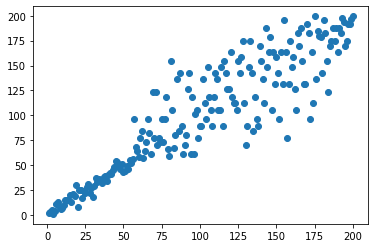

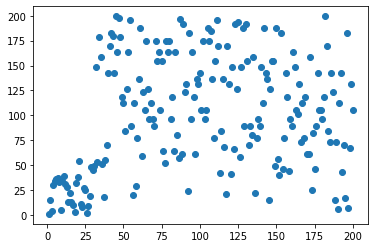

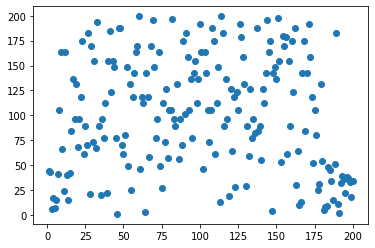

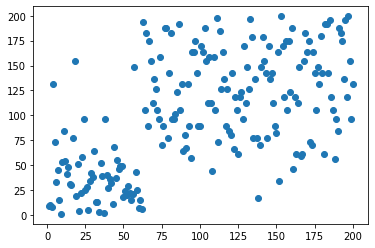

In [7]:
import matplotlib.pyplot as plt

plt.scatter(rank_confidences,rank_accs)
plt.show()

plt.scatter(rank_sensitivities,rank_accs)
plt.show()

plt.scatter(rank_robustnesses,rank_accs)
plt.show()

plt.scatter(rank_step_sims,rank_accs)
plt.show()

# Train a found model

In [8]:
trained_output = torch.load(os.path.join(xargs.save_dir, "output.pth"))
print(args)
args.save_dir = os.path.join(xargs.save_dir, "train")
print(args)

Namespace(arch_nas_dataset=None, channel=16, config_path='./MY.config', data_path='../cifar.python', dataset='cifar10', max_nodes=4, num_cells=5, print_freq=200, rand_seed=74964, save_dir='./cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200', search_space_name='nas-bench-201', select_num=100, track_running_stats=0, workers=4)
Namespace(arch_nas_dataset=None, channel=16, config_path='./MY.config', data_path='../cifar.python', dataset='cifar10', max_nodes=4, num_cells=5, print_freq=200, rand_seed=74964, save_dir='./cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train', search_space_name='nas-bench-201', select_num=100, track_running_stats=0, workers=4)


In [9]:
print(config)

Configure(scheduler='cos', LR=0.025, eta_min=0.001, epochs=50, warmup=0, optim='SGD', decay=0.0005, momentum=0.9, nesterov=True, criterion='Softmax', batch_size=64, test_batch_size=512, class_num=10, xshape=(1, 3, 32, 32))


In [10]:
logger = prepare_logger(args)

# cifar_train_config_path = "./MY.config"
cifar_train_config_path = "../configs/nas-benchmark/CIFAR.config"
###
train_data, test_data, xshape, class_num = get_datasets(xargs.dataset, xargs.data_path, -1)
config = load_config(cifar_train_config_path, {"class_num": class_num, "xshape": xshape}, logger)

train_loader = torch.utils.data.DataLoader(
            train_data,
            batch_size=config.batch_size,
            shuffle=True,
            num_workers=xargs.workers,
            pin_memory=True,)

test_loader = torch.utils.data.DataLoader(
            test_data,
            batch_size=config.batch_size,
            shuffle=True,
            num_workers=xargs.workers,
            pin_memory=True,)

# search_loader, _, valid_loader = get_nas_search_loaders(train_data,
#                                                         valid_data,
#                                                         xargs.dataset,
#                                                         "../configs/nas-benchmark/",
#                                                         (config.batch_size, config.batch_size),
#                                                         xargs.workers)
logger.log("||||||| {:10s} ||||||| Train-Loader-Num={:}, Test-Loader-Num={:}, batch size={:}".format(
            xargs.dataset, len(train_loader), len(test_loader), config.batch_size))
logger.log("||||||| {:10s} ||||||| Config={:}".format(xargs.dataset, config))

search_space = get_search_spaces("cell", xargs.search_space_name)
model_config = dict2config(
    {
        "name": "RANDOM",
        "C": xargs.channel,
        "N": xargs.num_cells,
        "max_nodes": xargs.max_nodes,
        "num_classes": class_num,
        "space": search_space,
        "affine": False,
        "track_running_stats": True, # true for eval
    },
    None,
)
search_model = get_cell_based_tiny_net(model_config)

### load
# trained_output = torch.load(os.path.join(xargs.save_dir, "output.pth"))
# search_model.load_state_dict(trained_output['model'], strict=False)
best_archs = trained_output['best_archs']
i=0
for m in search_model.modules():
    if isinstance(m, SearchCell):
        m.arch_cache = best_archs[i]
        i += 1
for m in network.modules():
    if isinstance(m, SearchCell):
        print(m.arch_cache)
###

w_optimizer, w_scheduler, criterion = get_optim_scheduler(search_model.parameters(), config)

logger.log("w-optimizer : {:}".format(w_optimizer))
logger.log("w-scheduler : {:}".format(w_scheduler))
logger.log("criterion   : {:}".format(criterion))

network, criterion = torch.nn.DataParallel(search_model).cuda(), criterion.cuda()

last_info, model_base_path, model_best_path = (
    logger.path("info"),
    logger.path("model"),
    logger.path("best"),
)

start_epoch, valid_accuracies, genotypes = 0, {"best": -1}, {}

Main Function with logger : Logger(dir=cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train, use-tf=False, writer=None)
Arguments : -------------------------------
arch_nas_dataset : None
channel          : 16
config_path      : ./MY.config
data_path        : ../cifar.python
dataset          : cifar10
max_nodes        : 4
num_cells        : 5
print_freq       : 200
rand_seed        : 74964
save_dir         : ./cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train
search_space_name : nas-bench-201
select_num       : 100
track_running_stats : 0
workers          : 4
Python  Version  : 3.7.13 (default, Mar 29 2022, 02:18:16)  [GCC 7.5.0]
Pillow  Version  : 9.0.1
PyTorch Version  : 1.12.0
cuDNN   Version  : 8302
CUDA available   : True
CUDA GPU numbers : 2
CUDA_VISIBLE_DEVICES : None
Files already downloaded and verified
Files already downloaded and verified
../configs/nas-benchmark/CIFAR.config
Configure(scheduler='cos', eta_min=0.0, epochs=200, warmup=0, optim

In [11]:
# def search_func_one_arch(xloader, network, criterion, scheduler, w_optimizer, epoch_str, print_freq, logger):
#     data_time, batch_time = AverageMeter(), AverageMeter()
#     base_losses, base_top1, base_top5 = AverageMeter(), AverageMeter(), AverageMeter()
#     network.train()
#     end = time.time()
#     for step, (base_inputs, base_targets, arch_inputs, arch_targets) in enumerate(
#         xloader
#     ):
#         scheduler.update(None, 1.0 * step / len(xloader))
#         base_targets = base_targets.cuda(non_blocking=True)
#         arch_targets = arch_targets.cuda(non_blocking=True)
#         # measure data loading time
#         data_time.update(time.time() - end)

#         w_optimizer.zero_grad()
#         _, logits = network(base_inputs)
#         base_loss = criterion(logits, base_targets)
#         base_loss.backward()
#         nn.utils.clip_grad_norm_(network.parameters(), 5)
#         w_optimizer.step()
#         # record
#         base_prec1, base_prec5 = obtain_accuracy(
#             logits.data, base_targets.data, topk=(1, 5)
#         )
#         base_losses.update(base_loss.item(), base_inputs.size(0))
#         base_top1.update(base_prec1.item(), base_inputs.size(0))
#         base_top5.update(base_prec5.item(), base_inputs.size(0))

#         # measure elapsed time
#         batch_time.update(time.time() - end)
#         end = time.time()

#         if step % print_freq == 0 or step + 1 == len(xloader):
#             Sstr = (
#                 "*SEARCH* "
#                 + time_string()
#                 + " [{:}][{:03d}/{:03d}]".format(epoch_str, step, len(xloader))
#             )
#             Tstr = "Time {batch_time.val:.2f} ({batch_time.avg:.2f}) Data {data_time.val:.2f} ({data_time.avg:.2f})".format(
#                 batch_time=batch_time, data_time=data_time
#             )
#             Wstr = "Base [Loss {loss.val:.3f} ({loss.avg:.3f})  Prec@1 {top1.val:.2f} ({top1.avg:.2f}) Prec@5 {top5.val:.2f} ({top5.avg:.2f})]".format(
#                 loss=base_losses, top1=base_top1, top5=base_top5
#             )
#             logger.log(Sstr + " " + Tstr + " " + Wstr)
#     return base_losses.avg, base_top1.avg, base_top5.avg

def train_func_one_arch(xloader, network, criterion, scheduler, w_optimizer, epoch_str, print_freq, logger):
    data_time, batch_time = AverageMeter(), AverageMeter()
    base_losses, base_top1, base_top5 = AverageMeter(), AverageMeter(), AverageMeter()
    network.train()
    end = time.time()
    for step, (base_inputs, base_targets) in enumerate(
        xloader
    ):
        scheduler.update(None, 1.0 * step / len(xloader))
        base_targets = base_targets.cuda(non_blocking=True)
        # measure data loading time
        data_time.update(time.time() - end)

        w_optimizer.zero_grad()
        _, logits = network(base_inputs)
        base_loss = criterion(logits, base_targets)
        base_loss.backward()
        nn.utils.clip_grad_norm_(network.parameters(), 5)
        w_optimizer.step()
        # record
        base_prec1, base_prec5 = obtain_accuracy(
            logits.data, base_targets.data, topk=(1, 5)
        )
        base_losses.update(base_loss.item(), base_inputs.size(0))
        base_top1.update(base_prec1.item(), base_inputs.size(0))
        base_top5.update(base_prec5.item(), base_inputs.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if step % print_freq == 0 or step + 1 == len(xloader):
            Sstr = (
                "*SEARCH* "
                + time_string()
                + " [{:}][{:03d}/{:03d}]".format(epoch_str, step, len(xloader))
            )
            Tstr = "Time {batch_time.val:.2f} ({batch_time.avg:.2f}) Data {data_time.val:.2f} ({data_time.avg:.2f})".format(
                batch_time=batch_time, data_time=data_time
            )
            Wstr = "Base [Loss {loss.val:.3f} ({loss.avg:.3f})  Prec@1 {top1.val:.2f} ({top1.avg:.2f}) Prec@5 {top5.val:.2f} ({top5.avg:.2f})]".format(
                loss=base_losses, top1=base_top1, top5=base_top5
            )
            logger.log(Sstr + " " + Tstr + " " + Wstr)
    return base_losses.avg, base_top1.avg, base_top5.avg

def valid_func_one_arch(xloader, network, criterion):
    data_time, batch_time = AverageMeter(), AverageMeter()
    arch_losses, arch_top1, arch_top5 = AverageMeter(), AverageMeter(), AverageMeter()
    network.eval()
    end = time.time()
    with torch.no_grad():
        for step, (arch_inputs, arch_targets) in enumerate(xloader):
            arch_targets = arch_targets.cuda(non_blocking=True)
            # measure data loading time
            data_time.update(time.time() - end)
            # prediction

#             network.module.random_genotype_per_cell(True)
            _, logits = network(arch_inputs)
            arch_loss = criterion(logits, arch_targets)
            # record
            arch_prec1, arch_prec5 = obtain_accuracy(
                logits.data, arch_targets.data, topk=(1, 5)
            )
            arch_losses.update(arch_loss.item(), arch_inputs.size(0))
            arch_top1.update(arch_prec1.item(), arch_inputs.size(0))
            arch_top5.update(arch_prec5.item(), arch_inputs.size(0))
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
    return arch_losses.avg, arch_top1.avg, arch_top5.avg

In [12]:
start_time, search_time, epoch_time, total_epoch = (
    time.time(),
    AverageMeter(),
    AverageMeter(),
    config.epochs + config.warmup,
)
for epoch in range(0, total_epoch):
    w_scheduler.update(epoch, 0.0)
    need_time = "Time Left: {:}".format(
        convert_secs2time(epoch_time.val * (total_epoch - epoch), True)
    )
    epoch_str = "{:03d}-{:03d}".format(epoch, total_epoch)
    logger.log(
        "\n[Search the {:}-th epoch] {:}, LR={:}".format(
            epoch_str, need_time, min(w_scheduler.get_lr())
        )
    )

    # selected_arch = search_find_best(valid_loader, network, criterion, xargs.select_num)
    search_w_loss, search_w_top1, search_w_top5 = train_func_one_arch(
        train_loader,
        network,
        criterion,
        w_scheduler,
        w_optimizer,
        epoch_str,
        xargs.print_freq,
        logger,
    )
    search_time.update(time.time() - start_time)
    logger.log(
        "[{:}] searching : loss={:.2f}, accuracy@1={:.2f}%, accuracy@5={:.2f}%, time-cost={:.1f} s".format(
            epoch_str, search_w_loss, search_w_top1, search_w_top5, search_time.sum
        )
    )
    valid_a_loss, valid_a_top1, valid_a_top5 = valid_func_one_arch(
        test_loader, network, criterion
    )
    logger.log(
        "[{:}] evaluate  : loss={:.2f}, accuracy@1={:.2f}%, accuracy@5={:.2f}%".format(
            epoch_str, valid_a_loss, valid_a_top1, valid_a_top5
        )
    )
    
    # check the best accuracy
    valid_accuracies[epoch] = valid_a_top1
    if valid_a_top1 > valid_accuracies["best"]:
        valid_accuracies["best"] = valid_a_top1
        find_best = True
    else:
        find_best = False

    # save checkpoint
    save_path = save_checkpoint(
        {
            "epoch": epoch + 1,
            "args": deepcopy(xargs),
            "search_model": search_model.state_dict(),
            "w_optimizer": w_optimizer.state_dict(),
            "w_scheduler": w_scheduler.state_dict(),
            "genotypes": genotypes,
            "valid_accuracies": valid_accuracies,
        },
        model_base_path,
        logger,
    )
    last_info = save_checkpoint(
        {
            "epoch": epoch + 1,
            "args": deepcopy(args),
            "last_checkpoint": save_path,
        },
        logger.path("info"),
        logger,
    )
    if find_best:
        logger.log(
            "<<<--->>> The {:}-th epoch : find the highest validation accuracy : {:.2f}%.".format(
                epoch_str, valid_a_top1
            )
        )
        copy_checkpoint(model_base_path, model_best_path, logger)
    if api is not None:
        logger.log("{:}".format(api.query_by_arch(genotypes[epoch], "200")))
    # measure elapsed time
    epoch_time.update(time.time() - start_time)
    start_time = time.time()

logger.close()


[Search the 000-200-th epoch] Time Left: [00:00:00], LR=0.1
*SEARCH* [2022-11-07 09:46:36] [000-200][000/196] Time 0.47 (0.47) Data 0.24 (0.24) Base [Loss 2.366 (2.366)  Prec@1 9.38 (9.38) Prec@5 46.48 (46.48)]
*SEARCH* [2022-11-07 09:47:06] [000-200][195/196] Time 0.15 (0.16) Data 0.00 (0.00) Base [Loss 1.419 (1.592)  Prec@1 46.25 (40.49) Prec@5 91.25 (88.63)]
[000-200] searching : loss=1.59, accuracy@1=40.49%, accuracy@5=88.63%, time-cost=30.5 s
[000-200] evaluate  : loss=1.51, accuracy@1=44.67%, accuracy@5=92.40%
save checkpoint into cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/checkpoint/seed-74964-basic.pth
save checkpoint into cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/seed-74964-last-info.pth
<<<--->>> The 000-200-th epoch : find the highest validation accuracy : 44.67%.
copy the file from cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/checkpoint/seed-74964-basic.pth into cell_level-arch_loop-no_reset_cell_par

*SEARCH* [2022-11-07 09:50:23] [007-200][000/196] Time 0.48 (0.48) Data 0.32 (0.32) Base [Loss 0.762 (0.762)  Prec@1 71.48 (71.48) Prec@5 99.22 (99.22)]
*SEARCH* [2022-11-07 09:50:54] [007-200][195/196] Time 0.10 (0.16) Data 0.00 (0.00) Base [Loss 0.680 (0.659)  Prec@1 80.00 (77.01) Prec@5 100.00 (98.80)]
[007-200] searching : loss=0.66, accuracy@1=77.01%, accuracy@5=98.80%, time-cost=232.4 s
[007-200] evaluate  : loss=1.12, accuracy@1=66.62%, accuracy@5=96.59%
Find cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/checkpoint/seed-74964-basic.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/checkpoint/seed-74964-basic.pth
Find cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/seed-74964-last-info.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/seed-74964-last-info.pth
<<<--->>> The 00

*SEARCH* [2022-11-07 09:54:15] [014-200][000/196] Time 0.32 (0.32) Data 0.21 (0.21) Base [Loss 0.521 (0.521)  Prec@1 80.08 (80.08) Prec@5 99.61 (99.61)]
*SEARCH* [2022-11-07 09:54:45] [014-200][195/196] Time 0.15 (0.15) Data 0.00 (0.00) Base [Loss 0.679 (0.545)  Prec@1 75.00 (81.22) Prec@5 96.25 (99.02)]
[014-200] searching : loss=0.54, accuracy@1=81.22%, accuracy@5=99.02%, time-cost=435.9 s
[014-200] evaluate  : loss=1.30, accuracy@1=61.24%, accuracy@5=98.46%
Find cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/checkpoint/seed-74964-basic.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/checkpoint/seed-74964-basic.pth
Find cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/seed-74964-last-info.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/seed-74964-last-info.pth

[Search the 015-

[021-200] evaluate  : loss=0.95, accuracy@1=70.60%, accuracy@5=98.21%
Find cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/checkpoint/seed-74964-basic.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/checkpoint/seed-74964-basic.pth
Find cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/seed-74964-last-info.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/seed-74964-last-info.pth

[Search the 022-200-th epoch] Time Left: [01:37:23], LR=0.09704403844771128
*SEARCH* [2022-11-07 09:58:40] [022-200][000/196] Time 0.41 (0.41) Data 0.22 (0.22) Base [Loss 0.474 (0.474)  Prec@1 83.98 (83.98) Prec@5 99.61 (99.61)]
*SEARCH* [2022-11-07 09:59:10] [022-200][195/196] Time 0.10 (0.16) Data 0.00 (0.00) Base [Loss 0.743 (0.484)  Prec@1 72.50 (83.38) Prec@5 98.75 (99.29)]
[022-200] searching : loss=0.

*SEARCH* [2022-11-07 10:03:00] [029-200][195/196] Time 0.11 (0.14) Data 0.00 (0.00) Base [Loss 0.641 (0.454)  Prec@1 80.00 (84.32) Prec@5 98.75 (99.41)]
[029-200] searching : loss=0.45, accuracy@1=84.32%, accuracy@5=99.41%, time-cost=872.5 s
[029-200] evaluate  : loss=1.07, accuracy@1=71.32%, accuracy@5=96.94%
Find cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/checkpoint/seed-74964-basic.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/checkpoint/seed-74964-basic.pth
Find cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/seed-74964-last-info.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/seed-74964-last-info.pth

[Search the 030-200-th epoch] Time Left: [01:30:18], LR=0.09455032620941839
*SEARCH* [2022-11-07 10:03:04] [030-200][000/196] Time 0.43 (0.43) Data 0.25 (0.25) Base [Los

*SEARCH* [2022-11-07 10:06:55] [036-200][195/196] Time 0.10 (0.15) Data 0.00 (0.00) Base [Loss 0.601 (0.437)  Prec@1 82.50 (84.88) Prec@5 98.75 (99.40)]
[036-200] searching : loss=0.44, accuracy@1=84.88%, accuracy@5=99.40%, time-cost=1080.1 s
[036-200] evaluate  : loss=0.69, accuracy@1=76.37%, accuracy@5=98.85%
Find cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/checkpoint/seed-74964-basic.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/checkpoint/seed-74964-basic.pth
Find cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/seed-74964-last-info.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/seed-74964-last-info.pth

[Search the 037-200-th epoch] Time Left: [01:30:58], LR=0.09179036806841352
*SEARCH* [2022-11-07 10:06:59] [037-200][000/196] Time 0.44 (0.44) Data 0.30 (0.30) Base [Lo

save checkpoint into cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/checkpoint/seed-74964-basic.pth
Find cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/seed-74964-last-info.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/seed-74964-last-info.pth

[Search the 044-200-th epoch] Time Left: [01:25:04], LR=0.08852566213878947
*SEARCH* [2022-11-07 10:10:49] [044-200][000/196] Time 0.43 (0.43) Data 0.30 (0.30) Base [Loss 0.470 (0.470)  Prec@1 82.81 (82.81) Prec@5 99.22 (99.22)]
*SEARCH* [2022-11-07 10:11:18] [044-200][195/196] Time 0.14 (0.15) Data 0.00 (0.00) Base [Loss 0.358 (0.411)  Prec@1 87.50 (85.90) Prec@5 98.75 (99.48)]
[044-200] searching : loss=0.41, accuracy@1=85.90%, accuracy@5=99.48%, time-cost=1314.2 s
[044-200] evaluate  : loss=0.76, accuracy@1=76.24%, accuracy@5=98.20%
Find cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/checkpoint/

*SEARCH* [2022-11-07 10:14:44] [051-200][000/196] Time 0.41 (0.41) Data 0.29 (0.29) Base [Loss 0.370 (0.370)  Prec@1 87.11 (87.11) Prec@5 99.22 (99.22)]
*SEARCH* [2022-11-07 10:15:13] [051-200][195/196] Time 0.25 (0.15) Data 0.00 (0.00) Base [Loss 0.623 (0.394)  Prec@1 78.75 (86.40) Prec@5 98.75 (99.52)]
[051-200] searching : loss=0.39, accuracy@1=86.40%, accuracy@5=99.52%, time-cost=1522.1 s
[051-200] evaluate  : loss=1.10, accuracy@1=70.46%, accuracy@5=98.57%
Find cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/checkpoint/seed-74964-basic.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/checkpoint/seed-74964-basic.pth
Find cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/seed-74964-last-info.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/seed-74964-last-info.pth

[Search the 052

*SEARCH* [2022-11-07 10:19:09] [059-200][000/196] Time 0.37 (0.37) Data 0.26 (0.26) Base [Loss 0.365 (0.365)  Prec@1 86.72 (86.72) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-07 10:19:38] [059-200][195/196] Time 0.15 (0.15) Data 0.00 (0.00) Base [Loss 0.369 (0.377)  Prec@1 87.50 (87.04) Prec@5 100.00 (99.56)]
[059-200] searching : loss=0.38, accuracy@1=87.04%, accuracy@5=99.56%, time-cost=1755.3 s
[059-200] evaluate  : loss=0.63, accuracy@1=79.59%, accuracy@5=98.92%
Find cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/checkpoint/seed-74964-basic.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/checkpoint/seed-74964-basic.pth
Find cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/seed-74964-last-info.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/seed-74964-last-info.pth

[Search the 

[066-200] evaluate  : loss=0.73, accuracy@1=77.64%, accuracy@5=97.85%
Find cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/checkpoint/seed-74964-basic.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/checkpoint/seed-74964-basic.pth
Find cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/seed-74964-last-info.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/seed-74964-last-info.pth

[Search the 067-200-th epoch] Time Left: [01:01:31], LR=0.07477293342162038
*SEARCH* [2022-11-07 10:23:26] [067-200][000/196] Time 0.46 (0.46) Data 0.30 (0.30) Base [Loss 0.358 (0.358)  Prec@1 85.16 (85.16) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-07 10:23:53] [067-200][195/196] Time 0.14 (0.14) Data 0.00 (0.00) Base [Loss 0.475 (0.357)  Prec@1 85.00 (87.62) Prec@5 100.00 (99.61)]
[067-200] searching : loss

*SEARCH* [2022-11-07 10:26:46] [074-200][000/196] Time 0.41 (0.41) Data 0.28 (0.28) Base [Loss 0.428 (0.428)  Prec@1 85.55 (85.55) Prec@5 98.83 (98.83)]
*SEARCH* [2022-11-07 10:27:11] [074-200][195/196] Time 0.13 (0.13) Data 0.00 (0.00) Base [Loss 0.543 (0.350)  Prec@1 80.00 (87.88) Prec@5 100.00 (99.62)]
[074-200] searching : loss=0.35, accuracy@1=87.88%, accuracy@5=99.62%, time-cost=2151.3 s
[074-200] evaluate  : loss=0.84, accuracy@1=76.22%, accuracy@5=97.30%
Find cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/checkpoint/seed-74964-basic.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/checkpoint/seed-74964-basic.pth
Find cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/seed-74964-last-info.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/seed-74964-last-info.pth

[Search the 07

[081-200] evaluate  : loss=0.57, accuracy@1=81.16%, accuracy@5=98.99%
Find cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/checkpoint/seed-74964-basic.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/checkpoint/seed-74964-basic.pth
Find cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/seed-74964-last-info.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/seed-74964-last-info.pth

[Search the 082-200-th epoch] Time Left: [00:51:15], LR=0.06394955530196147
*SEARCH* [2022-11-07 10:30:31] [082-200][000/196] Time 0.38 (0.38) Data 0.28 (0.28) Base [Loss 0.314 (0.314)  Prec@1 88.28 (88.28) Prec@5 99.61 (99.61)]
*SEARCH* [2022-11-07 10:30:54] [082-200][195/196] Time 0.15 (0.12) Data 0.00 (0.00) Base [Loss 0.298 (0.332)  Prec@1 90.00 (88.60) Prec@5 100.00 (99.65)]
[082-200] searching : loss=0

*SEARCH* [2022-11-07 10:33:47] [089-200][000/196] Time 0.37 (0.37) Data 0.23 (0.23) Base [Loss 0.266 (0.266)  Prec@1 91.80 (91.80) Prec@5 99.61 (99.61)]
*SEARCH* [2022-11-07 10:34:11] [089-200][195/196] Time 0.10 (0.13) Data 0.00 (0.00) Base [Loss 0.297 (0.313)  Prec@1 92.50 (89.23) Prec@5 98.75 (99.69)]
[089-200] searching : loss=0.31, accuracy@1=89.23%, accuracy@5=99.69%, time-cost=2516.8 s
[089-200] evaluate  : loss=0.52, accuracy@1=82.89%, accuracy@5=99.12%
Find cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/checkpoint/seed-74964-basic.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/checkpoint/seed-74964-basic.pth
Find cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/seed-74964-last-info.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/seed-74964-last-info.pth

[Search the 090

[096-200] evaluate  : loss=0.63, accuracy@1=80.87%, accuracy@5=99.04%
Find cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/checkpoint/seed-74964-basic.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/checkpoint/seed-74964-basic.pth
Find cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/seed-74964-last-info.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/seed-74964-last-info.pth

[Search the 097-200-th epoch] Time Left: [00:46:56], LR=0.052355322535482134
*SEARCH* [2022-11-07 10:37:40] [097-200][000/196] Time 0.40 (0.40) Data 0.22 (0.22) Base [Loss 0.282 (0.282)  Prec@1 89.06 (89.06) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-07 10:38:05] [097-200][195/196] Time 0.07 (0.13) Data 0.00 (0.00) Base [Loss 0.397 (0.299)  Prec@1 88.75 (89.56) Prec@5 98.75 (99.73)]
[097-200] searching : loss

*SEARCH* [2022-11-07 10:41:31] [104-200][195/196] Time 0.09 (0.13) Data 0.00 (0.00) Base [Loss 0.411 (0.282)  Prec@1 83.75 (90.19) Prec@5 100.00 (99.79)]
[104-200] searching : loss=0.28, accuracy@1=90.19%, accuracy@5=99.79%, time-cost=2901.3 s
[104-200] evaluate  : loss=0.48, accuracy@1=83.76%, accuracy@5=99.35%
Find cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/checkpoint/seed-74964-basic.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/checkpoint/seed-74964-basic.pth
Find cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/seed-74964-last-info.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/seed-74964-last-info.pth

[Search the 105-200-th epoch] Time Left: [00:44:23], LR=0.04607704521360776
*SEARCH* [2022-11-07 10:41:35] [105-200][000/196] Time 0.38 (0.38) Data 0.22 (0.22) Base [L

*SEARCH* [2022-11-07 10:44:57] [112-200][000/196] Time 0.49 (0.49) Data 0.30 (0.30) Base [Loss 0.294 (0.294)  Prec@1 89.45 (89.45) Prec@5 99.61 (99.61)]
*SEARCH* [2022-11-07 10:45:21] [112-200][195/196] Time 0.09 (0.12) Data 0.00 (0.00) Base [Loss 0.281 (0.262)  Prec@1 91.25 (90.97) Prec@5 100.00 (99.80)]
[112-200] searching : loss=0.26, accuracy@1=90.97%, accuracy@5=99.80%, time-cost=3101.4 s
[112-200] evaluate  : loss=0.66, accuracy@1=79.93%, accuracy@5=98.97%
Find cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/checkpoint/seed-74964-basic.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/checkpoint/seed-74964-basic.pth
Find cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/seed-74964-last-info.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/seed-74964-last-info.pth

[Search the 11

[119-200] evaluate  : loss=0.60, accuracy@1=81.55%, accuracy@5=99.43%
Find cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/checkpoint/seed-74964-basic.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/checkpoint/seed-74964-basic.pth
Find cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/seed-74964-last-info.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/seed-74964-last-info.pth

[Search the 120-200-th epoch] Time Left: [00:38:46], LR=0.03454915028125265
*SEARCH* [2022-11-07 10:48:59] [120-200][000/196] Time 0.36 (0.36) Data 0.25 (0.25) Base [Loss 0.220 (0.220)  Prec@1 93.36 (93.36) Prec@5 99.61 (99.61)]
*SEARCH* [2022-11-07 10:49:27] [120-200][195/196] Time 0.13 (0.14) Data 0.00 (0.00) Base [Loss 0.246 (0.243)  Prec@1 93.75 (91.64) Prec@5 100.00 (99.84)]
[120-200] searching : loss=0

[126-200] evaluate  : loss=0.47, accuracy@1=84.53%, accuracy@5=99.41%
Find cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/checkpoint/seed-74964-basic.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/checkpoint/seed-74964-basic.pth
Find cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/seed-74964-last-info.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/seed-74964-last-info.pth

[Search the 127-200-th epoch] Time Left: [00:33:47], LR=0.029424282069744564
*SEARCH* [2022-11-07 10:52:34] [127-200][000/196] Time 0.50 (0.50) Data 0.30 (0.30) Base [Loss 0.234 (0.234)  Prec@1 92.58 (92.58) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-07 10:52:59] [127-200][195/196] Time 0.14 (0.13) Data 0.00 (0.00) Base [Loss 0.191 (0.222)  Prec@1 92.50 (92.30) Prec@5 100.00 (99.85)]
[127-200] searching : los

*SEARCH* [2022-11-07 10:56:26] [134-200][195/196] Time 0.14 (0.14) Data 0.00 (0.00) Base [Loss 0.399 (0.199)  Prec@1 86.25 (93.04) Prec@5 98.75 (99.90)]
[134-200] searching : loss=0.20, accuracy@1=93.04%, accuracy@5=99.90%, time-cost=3689.4 s
[134-200] evaluate  : loss=0.45, accuracy@1=85.83%, accuracy@5=99.39%
Find cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/checkpoint/seed-74964-basic.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/checkpoint/seed-74964-basic.pth
Find cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/seed-74964-last-info.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/seed-74964-last-info.pth

[Search the 135-200-th epoch] Time Left: [00:34:38], LR=0.02387507176420256
*SEARCH* [2022-11-07 10:56:31] [135-200][000/196] Time 0.33 (0.33) Data 0.23 (0.23) Base [Lo

*SEARCH* [2022-11-07 10:59:50] [142-200][000/196] Time 0.35 (0.35) Data 0.24 (0.24) Base [Loss 0.148 (0.148)  Prec@1 94.92 (94.92) Prec@5 99.61 (99.61)]
*SEARCH* [2022-11-07 11:00:15] [142-200][195/196] Time 0.09 (0.13) Data 0.00 (0.00) Base [Loss 0.334 (0.172)  Prec@1 88.75 (93.93) Prec@5 100.00 (99.92)]
[142-200] searching : loss=0.17, accuracy@1=93.93%, accuracy@5=99.92%, time-cost=3890.6 s
[142-200] evaluate  : loss=0.50, accuracy@1=85.21%, accuracy@5=99.40%
Find cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/checkpoint/seed-74964-basic.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/checkpoint/seed-74964-basic.pth
Find cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/seed-74964-last-info.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/seed-74964-last-info.pth

[Search the 14

*SEARCH* [2022-11-07 11:03:03] [149-200][000/196] Time 0.40 (0.40) Data 0.30 (0.30) Base [Loss 0.119 (0.119)  Prec@1 96.09 (96.09) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-07 11:03:27] [149-200][195/196] Time 0.09 (0.13) Data 0.00 (0.00) Base [Loss 0.120 (0.150)  Prec@1 95.00 (94.80) Prec@5 100.00 (99.95)]
[149-200] searching : loss=0.15, accuracy@1=94.80%, accuracy@5=99.95%, time-cost=4058.4 s
[149-200] evaluate  : loss=0.42, accuracy@1=87.90%, accuracy@5=99.50%
Find cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/checkpoint/seed-74964-basic.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/checkpoint/seed-74964-basic.pth
Find cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/seed-74964-last-info.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/seed-74964-last-info.pth

[Search the 

[156-200] evaluate  : loss=0.39, accuracy@1=88.64%, accuracy@5=99.69%
Find cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/checkpoint/seed-74964-basic.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/checkpoint/seed-74964-basic.pth
Find cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/seed-74964-last-info.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/seed-74964-last-info.pth

[Search the 157-200-th epoch] Time Left: [00:20:41], LR=0.010978479633083522
*SEARCH* [2022-11-07 11:06:58] [157-200][000/196] Time 0.41 (0.41) Data 0.28 (0.28) Base [Loss 0.100 (0.100)  Prec@1 96.48 (96.48) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-07 11:07:25] [157-200][195/196] Time 0.23 (0.14) Data 0.00 (0.00) Base [Loss 0.123 (0.117)  Prec@1 96.25 (95.98) Prec@5 100.00 (99.96)]
[157-200] searching : los

[163-200] evaluate  : loss=0.36, accuracy@1=89.87%, accuracy@5=99.59%
Find cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/checkpoint/seed-74964-basic.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/checkpoint/seed-74964-basic.pth
Find cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/seed-74964-last-info.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/seed-74964-last-info.pth

[Search the 164-200-th epoch] Time Left: [00:17:01], LR=0.007783603724899258
*SEARCH* [2022-11-07 11:10:20] [164-200][000/196] Time 0.41 (0.41) Data 0.25 (0.25) Base [Loss 0.056 (0.056)  Prec@1 98.05 (98.05) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-07 11:10:44] [164-200][195/196] Time 0.13 (0.13) Data 0.00 (0.00) Base [Loss 0.166 (0.092)  Prec@1 95.00 (96.90) Prec@5 100.00 (99.97)]
[164-200] searching : los

*SEARCH* [2022-11-07 11:13:38] [171-200][000/196] Time 0.37 (0.37) Data 0.25 (0.25) Base [Loss 0.091 (0.091)  Prec@1 96.88 (96.88) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-07 11:14:06] [171-200][195/196] Time 0.15 (0.15) Data 0.00 (0.00) Base [Loss 0.103 (0.067)  Prec@1 96.25 (97.78) Prec@5 100.00 (99.99)]
[171-200] searching : loss=0.07, accuracy@1=97.78%, accuracy@5=99.99%, time-cost=4617.0 s
[171-200] evaluate  : loss=0.37, accuracy@1=90.00%, accuracy@5=99.69%
Find cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/checkpoint/seed-74964-basic.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/checkpoint/seed-74964-basic.pth
Find cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/seed-74964-last-info.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/seed-74964-last-info.pth

[Search the 

*SEARCH* [2022-11-07 11:17:01] [177-200][195/196] Time 0.10 (0.13) Data 0.00 (0.00) Base [Loss 0.100 (0.052)  Prec@1 96.25 (98.36) Prec@5 100.00 (99.99)]
[177-200] searching : loss=0.05, accuracy@1=98.36%, accuracy@5=99.99%, time-cost=4770.0 s
[177-200] evaluate  : loss=0.35, accuracy@1=90.56%, accuracy@5=99.73%
Find cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/checkpoint/seed-74964-basic.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/checkpoint/seed-74964-basic.pth
Find cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/seed-74964-last-info.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/seed-74964-last-info.pth

[Search the 178-200-th epoch] Time Left: [00:10:17], LR=0.0029559615522887273
*SEARCH* [2022-11-07 11:17:04] [178-200][000/196] Time 0.40 (0.40) Data 0.22 (0.22) Base 

*SEARCH* [2022-11-07 11:19:56] [185-200][000/196] Time 0.33 (0.33) Data 0.22 (0.22) Base [Loss 0.035 (0.035)  Prec@1 98.44 (98.44) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-07 11:20:14] [185-200][195/196] Time 0.07 (0.09) Data 0.00 (0.00) Base [Loss 0.057 (0.037)  Prec@1 98.75 (98.94) Prec@5 100.00 (100.00)]
[185-200] searching : loss=0.04, accuracy@1=98.94%, accuracy@5=100.00%, time-cost=4937.6 s
[185-200] evaluate  : loss=0.34, accuracy@1=91.32%, accuracy@5=99.72%
Find cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/checkpoint/seed-74964-basic.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/checkpoint/seed-74964-basic.pth
Find cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/seed-74964-last-info.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/seed-74964-last-info.pth
<<<--->>> T

[192-200] evaluate  : loss=0.35, accuracy@1=91.20%, accuracy@5=99.72%
Find cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/checkpoint/seed-74964-basic.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/checkpoint/seed-74964-basic.pth
Find cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/seed-74964-last-info.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-no_reset_cell_params-loop5_ep2_sample200/train/seed-74964-last-info.pth

[Search the 193-200-th epoch] Time Left: [00:02:35], LR=0.00030195222724102024
*SEARCH* [2022-11-07 11:23:03] [193-200][000/196] Time 0.34 (0.34) Data 0.22 (0.22) Base [Loss 0.018 (0.018)  Prec@1 99.22 (99.22) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-07 11:23:23] [193-200][195/196] Time 0.13 (0.10) Data 0.00 (0.00) Base [Loss 0.044 (0.030)  Prec@1 98.75 (99.22) Prec@5 100.00 (100.00)]
[193-200] searching : 

In [13]:
best_archs

[Structure(4 nodes with |avg_pool_3x3~0|+|avg_pool_3x3~0|none~1|+|nor_conv_3x3~0|skip_connect~1|none~2|),
 Structure(4 nodes with |avg_pool_3x3~0|+|skip_connect~0|nor_conv_1x1~1|+|skip_connect~0|none~1|none~2|),
 Structure(4 nodes with |nor_conv_1x1~0|+|skip_connect~0|nor_conv_3x3~1|+|nor_conv_3x3~0|skip_connect~1|nor_conv_3x3~2|),
 Structure(4 nodes with |avg_pool_3x3~0|+|nor_conv_1x1~0|avg_pool_3x3~1|+|nor_conv_3x3~0|none~1|none~2|),
 Structure(4 nodes with |nor_conv_3x3~0|+|skip_connect~0|none~1|+|skip_connect~0|nor_conv_1x1~1|none~2|),
 Structure(4 nodes with |avg_pool_3x3~0|+|nor_conv_1x1~0|avg_pool_3x3~1|+|none~0|nor_conv_3x3~1|nor_conv_3x3~2|),
 Structure(4 nodes with |nor_conv_3x3~0|+|avg_pool_3x3~0|nor_conv_1x1~1|+|avg_pool_3x3~0|none~1|skip_connect~2|),
 Structure(4 nodes with |nor_conv_3x3~0|+|skip_connect~0|none~1|+|none~0|avg_pool_3x3~1|skip_connect~2|),
 Structure(4 nodes with |skip_connect~0|+|avg_pool_3x3~0|avg_pool_3x3~1|+|nor_conv_3x3~0|none~1|skip_connect~2|),
 Struc